In [2]:
import pandas as pd
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from textblob import TextBlob
import matplotlib.pyplot as plt
import numpy as np

# %install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime
%matplotlib inline

In [ ]:
df = pd.read_csv('./shooting_text_snippets.csv', index_col='ia_show_id')

In [ ]:
df.shape

In [ ]:
def process_content(df, col):
    
    stop_words = stopwords.words('english')

    # tokenization
    df['tokenized_words'] = df[col].apply(word_tokenize)
    
    # removing stop words
    df['tokenized_stopped'] = df['tokenized_words'].apply(lambda x: [item for item in x if item not in stop_words])
    
    # POS tagging
    df['tagged_stopped'] = df['tokenized_stopped'].apply(lambda x: nltk.pos_tag(x))
    df['tagged'] = df['tokenized_words'].apply(lambda x: nltk.pos_tag(x))

    # Selecting adjectives
    is_adj = lambda pos: pos[:2].__contains__('JJ')
    df['adjectives'] = df['tagged_stopped'].apply(lambda x: [word for (word, pos) in x if is_adj(pos)])
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    df['lemmatized'] = df['adjectives'].apply(lambda x: [lemmatizer.lemmatize(item) for item in x])
    
    # Cleaning the result
    df['lemmatized'].str.lower()
    df['lemmatized'] = df['lemmatized'].apply(lambda x: [w for w in x if w.isalpha()])

    return df

df = process_content(df, 'snippet')

In [ ]:
df.to_csv('./df_new_0410.csv')

In [ ]:
df = pd.read_csv('./df_new_0410.csv')

In [ ]:
df.reset_index(inplace=True)
df_grouped = pd.DataFrame(df.groupby('ia_show_id')['lemmatized'].apply(lambda x: x.sum()))
df_grouped.head()

In [ ]:
# nltk.FreqDist(df_grouped[''])     ### this can be used later
# most_common(15)

In [ ]:
def sent_score(word):
    score = 0
    a = TextBlob(word).sentiment
    score += (a.polarity * a.subjectivity)
    return score

In [ ]:
df_grouped['score'] = df_grouped['lemmatized'].apply(lambda x: [sent_score(item) for item in x])
df_grouped['sentiment'] = df_grouped['score'].apply(lambda x: sum(x))

In [ ]:
df_grouped.reset_index(inplace=True)

In [ ]:
df_new = pd.read_csv('./grouped_sentiment_0410.csv')

###  Classification

In [84]:
df = pd.read_csv('./sentiments_with_race.csv')
df.shape

(2532, 16)

time: 99.7 ms


In [89]:
df = df[df['Race'] != 'nan']

time: 4.31 ms


## Modeling

In [75]:
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

time: 2.92 ms


### preprocessing

In [76]:
normalizer = Normalizer()
score_scaled = normalizer.fit_transform(df['sentiment'])
df['score_norm'] = score_scaled[0]

df['Gender'] = df['Gender'].str.replace('Male','M')
df['Injured'] = df['Injured'].replace({r"[a-zA-Z]", ''}, regex=True)

time: 11.3 ms


/Users/Amiros/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/Amiros/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [39]:
# subset X and y
# X = df[['Fatalities', 'Injured', 'Total victims']]
# one_hot = pd.get_dummies(df[['Venue', 'Race', 'Gender']])

# X = pd.concat([X, one_hot], axis=1)
X = pd.get_dummies(df[['Race', 'Gender']])

time: 11.9 ms


In [40]:
y = df['score_norm']

time: 1.06 ms


In [54]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, random_state=0, test_size=0.05)

time: 2.76 ms


In [55]:
train_scores = []
test_scores = []

rf = RandomForestRegressor(bootstrap=True, warm_start=True)
estimator_range = range(1, 100, 5)
for n_estimators in estimator_range:
    rf.n_estimators = n_estimators
    rf.fit(X_train, y_train)
    train_scores.append(rf.score(X_train, y_train))
    test_scores.append(rf.score(X_test, y_test))

time: 449 ms


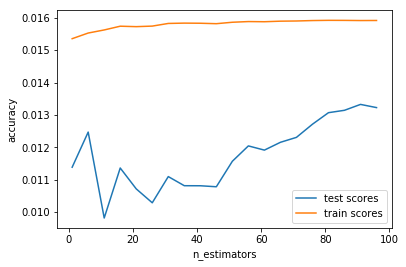

time: 260 ms


In [57]:
plt.plot(estimator_range, test_scores, label="test scores")
plt.plot(estimator_range, train_scores, label="train scores")
plt.ylabel("accuracy")
plt.xlabel("n_estimators")
plt.legend()

In [58]:
rf.feature_importances_

array([ 0.05160308,  0.09645071,  0.11874188,  0.09664916,  0.22638296,
        0.09767129,  0.04231126,  0.04603317,  0.22415649])

time: 14.2 ms


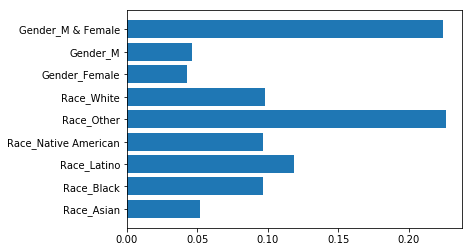

time: 267 ms


In [59]:
plt.barh(range(rf.feature_importances_.shape[0]), rf.feature_importances_)
plt.yticks(range(rf.feature_importances_.shape[0]), X.columns);

In [60]:
gbrt = GradientBoostingRegressor().fit(X_train, y_train)
gbrt.score(X_test, y_test)

0.011722217211503683

time: 105 ms


In [61]:
param_grid = {'learning_rate': [.5, .2, .1, .05, .02, .01, .001]}
grid = GridSearchCV(GradientBoostingRegressor(), param_grid=param_grid, cv=10)
grid.fit(X_train, y_train);

time: 5.67 s


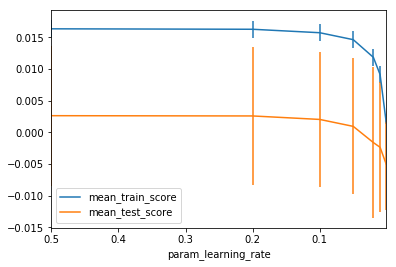

time: 284 ms


In [62]:
scores = pd.DataFrame(grid.cv_results_)

scores.plot(x='param_learning_rate', y='mean_train_score', yerr='std_train_score', ax=plt.gca())
scores.plot(x='param_learning_rate', y='mean_test_score', yerr='std_test_score', ax=plt.gca())

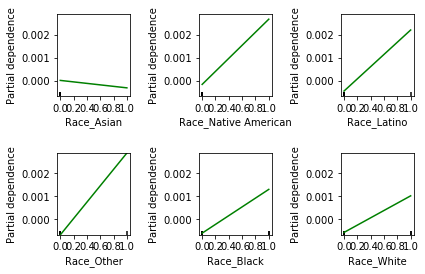

time: 1.13 s


In [63]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence
fig, axs = plot_partial_dependence(gbrt, X_train, np.argsort(gbrt.feature_importances_)[-6:],
                                       feature_names=X.columns,
                                       n_jobs=3, grid_resolution=50)
plt.tight_layout()

In [ ]:
### binary race white-non-white

In [91]:
df['Race'] = df['Race'].str.replace('White', '0')
df['Race'] = df['Race'].str.replace('Native American', '1')
df['Race'] = df['Race'].str.replace('Latino', '1')
df['Race'] = df['Race'].str.replace('Other', '1')
df['Race'] = df['Race'].str.replace('Black', '1')
df['Race'] = df['Race'].str.replace('Asian', '1')



time: 27.4 ms


In [92]:
df['Race'].unique()

array(['1', '0', nan], dtype=object)

time: 4.32 ms


array([1], dtype=object)

time: 4.37 ms
